In [1]:
# Imports

import math, pickle, os, copy, sys, scipy.io
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# do not show warnings
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from samples.data_sim import PVDataset
from feature_selection import tune_pacf, rfecv_selection
from samples.data_sim import remove_feature

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

#### FL

import json

import torch
import torch.optim as optim

import numpy as np
from torch.utils.data import DataLoader, Subset

from trainer import Trainer

from models import *

from metrics import mse

from tqdm import tqdm

### Data generation

In [2]:
months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

# Generate data for 1 client

train_year = [2018]
valid_year = 2019

generate_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

hour_begin = 8
hour_end = 18

num_clients=1

city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std': 0, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': get_available_modules('sandia')[0:num_clients], #['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': get_available_inverters('cec')[0:num_clients], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1], 'months':generate_months, 'hours':np.arange(hour_begin, hour_end), 
            'train_scenarios':{'1y':{'m_train':None, 'train_years':train_year, 'valid_years':valid_year}}}

env_dict = PVDataset(env_dict).generate_clients_data()

[INFO] generating data for Lausanne


In [3]:
def access_data(env_dict, client_id=0):
    """ 
    Access data for a specific client
    """
    
    clients_data = env_dict['train_scenarios']['1y']['clients_data']
    # time_series = env_dict['train_scenarios']['1y']['time_series']
    
    x_train, y_train, x_valid, y_valid = clients_data[client_id]
    
    # normalize data
    x_mean = np.mean(x_train, axis=0)
    x_std = np.std(x_train, axis=0)
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)

    x_train = (x_train - x_mean) / x_std
    y_train = (y_train - y_mean) / y_std
    x_valid = (x_valid - x_mean) / x_std
    y_valid = (y_valid - y_mean) / y_std
    
    return x_train, y_train, x_valid, y_valid

def get_nbr_values_per_month(env_dict):
    """
    Get the number of values per month
    """
    time_series = env_dict['train_scenarios']['1y']['time_series']

    client_id = 0
    time_series = time_series[client_id]

    time_series = time_series[(time_series.year.isin(train_year)) & (time_series.month.isin(generate_months)) & (time_series.hour_day.isin(np.arange(hour_begin, hour_end)))]

    nbr_values_per_month = time_series.groupby('month')['time'].count().reset_index()

    # change the type of the columns to int
    nbr_values_per_month = nbr_values_per_month.astype(int)
    
    return nbr_values_per_month

### 0. Visualizing the data

In [4]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


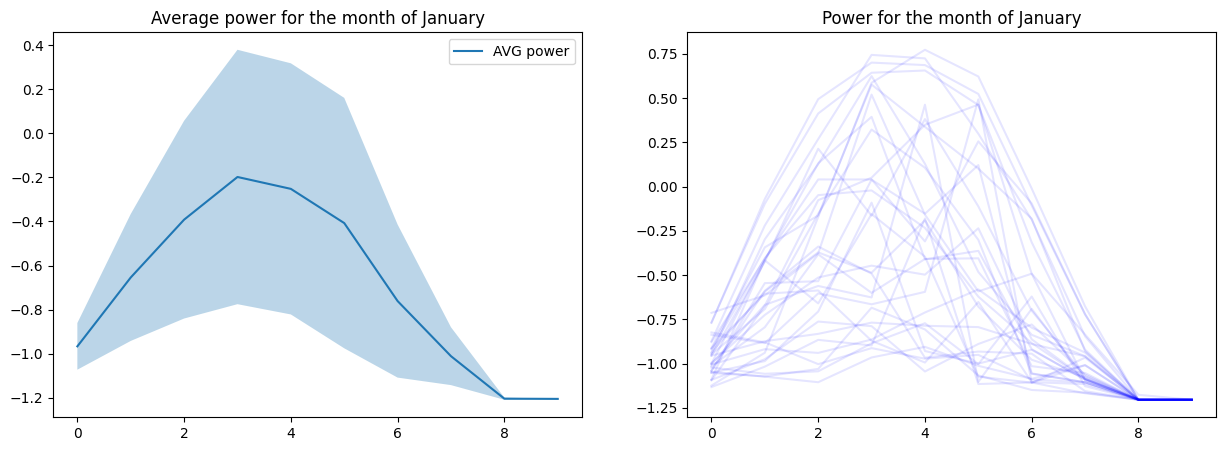

In [5]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)

month = 1

month_idx_begin = nbr_values_per_month.time[0:month-1].sum()
month_idx_end = nbr_values_per_month.time[0:month].sum()

# Plot the power values for a specific month
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.mean(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0), label='AVG power')
plt.fill_between(np.arange(0, len(np.mean(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0))), np.mean(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0) - np.std(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0) + np.std(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)), axis=0), alpha=0.3)
plt.title('Average power for the month of {}'.format(months_name[month]))
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_train[month_idx_begin:month_idx_end].reshape(-1, (hour_end-hour_begin)).T, color='blue', alpha=0.1)
plt.title('Power for the month of {}'.format(months_name[month]))
plt.show()

### 1. One model for 3 months

> Train a model using 3 consecutive months of data, predict the same three months of the next year.

In [6]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [7]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [8]:
# Filter the data for three selected months (continuous)
selected_months = [7, 8, 9]

months_idx_begin = nbr_values_per_month.time[0:selected_months[0]-1].sum()
months_idx_end = nbr_values_per_month.time[0:selected_months[-1]].sum()

x_train = x_train[months_idx_begin:months_idx_end, :]
y_train = y_train[months_idx_begin:months_idx_end]
x_valid = x_valid[months_idx_begin:months_idx_end, :]
y_valid = y_valid[months_idx_begin:months_idx_end]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((920, 10), (920, 1), (920, 10), (920, 1))

In [9]:
NUM_EPOCHS = 300

LR_GRID = [1e-3, 1e-2, 1e-1]
SEED_GRID = [1956]

SAVE_PATH = 'scenario1.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [10]:
# Run experiments

all_results_dict = dict()
for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        
        print(f"Seed: {seed_} | LR: {lr_}")
        
        ###### Define the model, optimizer, loss function and history
        training_loss_history = []
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)

        # Create the model, optimizer, and trainer
        model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)

        optimizer = optim.SGD(
            [param for param in model.parameters() if param.requires_grad],
            lr=lr_,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainer = Trainer(
            model=model,
            criterion=nn.MSELoss(reduction='none').to(DEVICE),
            metric=mse,
            device=DEVICE,
            optimizer=optimizer,
            cast_label=False,
        )
        
        ###### Define training data
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
        
        ###### Training loop
        for epoch in tqdm(range(NUM_EPOCHS)):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            ## Training Loss
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
        
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
            # print(f"Epoch: {epoch} | Training Loss: {loss_stream:0.3f}")
            
        ###### Test the model
        outs_valid = trainer.model(torch.tensor(x_valid).to(DEVICE).type(torch.float32))
        loss_valid = trainer.criterion(outs_valid, torch.tensor(y_valid).to(DEVICE).type(torch.float32)).mean()
        
        print(f"Validation Loss: {loss_valid:0.3f}")
        
        # Save the results in a json file
        all_results_dict[seed_][lr_] = {'training_loss': training_loss_history,
                                        'validation_loss': loss_valid.detach().cpu().numpy(),
                                        'outs_valid': outs_valid.detach().cpu().numpy(),
                                        'y_valid': y_valid}
        
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())

Seed: 1956 | LR: 0.001


100%|██████████| 300/300 [00:00<00:00, 566.42it/s]


Validation Loss: 0.181
Seed: 1956 | LR: 0.01


100%|██████████| 300/300 [00:00<00:00, 618.79it/s]


Validation Loss: 0.153
Seed: 1956 | LR: 0.1


100%|██████████| 300/300 [00:00<00:00, 641.48it/s]

Validation Loss: 0.150


In [11]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

all_results_dict
# convert this a df with the columns seed, lr, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'training_loss', 'validation_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        df = df.append({'seed': seed,
                        'lr': lr,
                        'training_loss': all_results_dict[seed][lr]['training_loss'],
                        'validation_loss': all_results_dict[seed][lr]['validation_loss'],
                        'outs_valid': all_results_dict[seed][lr]['outs_valid'],
                        'y_valid': all_results_dict[seed][lr]['y_valid']}, ignore_index=True)
        
df

,seed,lr,training_loss,validation_loss,outs_valid,y_valid
0,1956,0.001,"[1.1249858140945435, 1.1765587329864502, 1.124...",0.181249,"[[0.24384015798568726], [0.9718923568725586], ...","[[0.14651128711792677], [1.1056118896677205], ..."
1,1956,0.01,"[1.1249858140945435, 1.161592721939087, 1.0845...",0.152740,"[[0.28891968727111816], [0.8769912719726562], ...","[[0.14651128711792677], [1.1056118896677205], ..."
2,1956,0.1,"[1.1249858140945435, 1.0381858348846436, 0.882...",0.150411,"[[0.2597320079803467], [0.9682910442352295], [...","[[0.14651128711792677], [1.1056118896677205], ..."


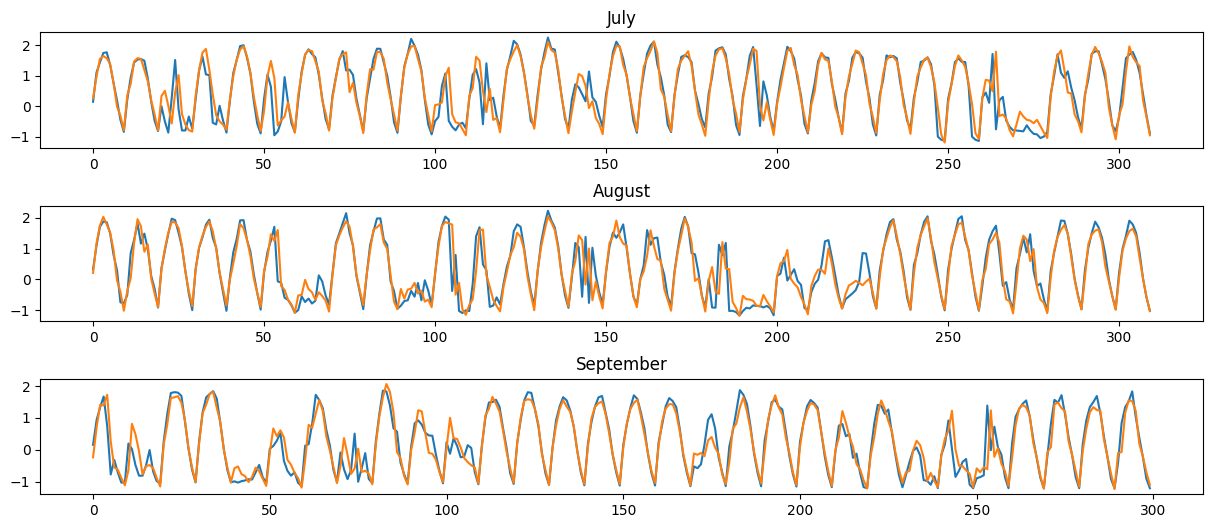

In [12]:
seed = '1956'
lr = '0.1'

outs_valid = df[(df.seed == seed) & (df.lr == lr)]['outs_valid'].values[0]
y_valid = df[(df.seed == seed) & (df.lr == lr)]['y_valid'].values[0]

# using selected_months, plot the power values for the three selected months compared with the predicted values
plt.figure(figsize=(15, 2*len(selected_months)))
plt.subplots_adjust(hspace=0.5)
for ind, month in enumerate(selected_months):
    month_idx_begin = nbr_values_per_month.time[0:month-1].sum() - nbr_values_per_month.time[0:selected_months[0]-1].sum()
    month_idx_end = nbr_values_per_month.time[0:month].sum() - nbr_values_per_month.time[0:selected_months[0]-1].sum()
    
    y_valid_month = y_valid[month_idx_begin:month_idx_end]
    outs_valid_month = outs_valid[month_idx_begin:month_idx_end]
    
    plt.subplot(len(selected_months), 1, ind+1)
    plt.plot(y_valid_month, label='True power')
    plt.plot(outs_valid_month, label='Predicted power')
    plt.title(months_name[month])

> The results are good, since most days are relatively similar, the model probably overfits and predicts using a similar day from the previous year. 

### 2. One model per month
> Train a model using one month of data, predict the same month of the next year.

In [13]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [14]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [15]:
NUM_EPOCHS = 300

LR_GRID = [1e-3, 1e-2, 1e-1]
SEED_GRID = [1956]

SAVE_PATH = 'scenario2.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [16]:
# Run experiments
all_results_dict = dict()
for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        
        print(f"\nSeed: {seed_} | LR: {lr_}")
        
        outs_valid_history = []
        
        # Loop over the months
        for index, row in nbr_values_per_month.iterrows():
            all_results_dict[seed_][lr_][months_name[row.month]] = dict()
            
            x_train_month = x_train[index*row['time']:(index+1)*row['time'], :]
            y_train_month = y_train[index*row['time']:(index+1)*row['time']]
            x_valid_month = x_valid[index*row['time']:(index+1)*row['time'], :]
            y_valid_month = y_valid[index*row['time']:(index+1)*row['time']]
        
            ###### Define training data
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
            train_dataloader = DataLoader(train_dataset, batch_size=155, shuffle=True)
            train_iterator = iter(train_dataloader)
            
            ###### Define the model, optimizer, loss function and history
            training_loss_history = []
            
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = True
            torch.manual_seed(seed_)

            # Create the model, optimizer, and trainer
            # model = LinearLayer(input_dim=10, output_dim=1, bias=True).to(DEVICE)
            model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)

            optimizer = optim.SGD(
                [param for param in model.parameters() if param.requires_grad],
                lr=lr_,
                momentum=0.9,
                weight_decay=5e-4
            )

            trainer = Trainer(
                model=model,
                criterion=nn.MSELoss(reduction='none').to(DEVICE),
                metric=mse,
                device=DEVICE,
                optimizer=optimizer,
                cast_label=False,
            )
            
            ###### Training loop
            for epoch in tqdm(range(NUM_EPOCHS)):
            
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                ## Training Loss
                try:
                    x_stream, y_stream = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_stream, y_stream = next(train_iterator)
            
                x_stream = x_stream.to(DEVICE).type(torch.float32)
                y_stream = y_stream.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_stream = trainer.model(x_stream)
                loss_stream = trainer.criterion(outs_stream, y_stream).mean()
                loss = loss_stream
                
                training_loss_history.append(loss_stream.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                # print(f"Epoch: {epoch} | Training Loss: {loss:0.3f}")
                
            ###### Test the model
            outs_valid = trainer.model(torch.tensor(x_valid_month).to(DEVICE).type(torch.float32))
            outs_valid_history.append(outs_valid.detach().cpu().numpy())
            loss_valid = trainer.criterion(outs_valid, torch.tensor(y_valid_month).to(DEVICE).type(torch.float32)).mean()
            print(f'Month: {months_name[row.month]} | Validation Loss: {loss_valid:0.3f}')
            
            # Save the results in a json file
            all_results_dict[seed_][lr_][months_name[row.month]] = {'training_loss': training_loss_history,
                                                        'validation_loss': loss_valid.detach().cpu().numpy().tolist(),
                                                        'outs_valid': outs_valid.detach().cpu().numpy(),
                                                        'y_valid': y_valid_month}
                
            with open(SAVE_PATH, 'w') as f:
                json.dump(all_results_dict, f, default=lambda x: x.tolist())
    


Seed: 1956 | LR: 0.001


100%|██████████| 300/300 [00:00<00:00, 1642.22it/s]


Month: January | Validation Loss: 0.137


100%|██████████| 300/300 [00:00<00:00, 1943.60it/s]


Month: February | Validation Loss: 0.243


100%|██████████| 300/300 [00:00<00:00, 1818.14it/s]


Month: March | Validation Loss: 0.453


100%|██████████| 300/300 [00:00<00:00, 1849.10it/s]


Month: April | Validation Loss: 0.261


100%|██████████| 300/300 [00:00<00:00, 1799.31it/s]


Month: May | Validation Loss: 0.250


100%|██████████| 300/300 [00:00<00:00, 1798.90it/s]


Month: June | Validation Loss: 0.157


100%|██████████| 300/300 [00:00<00:00, 1770.85it/s]


Month: July | Validation Loss: 0.181


100%|██████████| 300/300 [00:00<00:00, 1799.80it/s]


Month: August | Validation Loss: 0.222


100%|██████████| 300/300 [00:00<00:00, 1873.83it/s]


Month: September | Validation Loss: 0.138


100%|██████████| 300/300 [00:00<00:00, 1494.25it/s]


Month: October | Validation Loss: 0.179


100%|██████████| 300/300 [00:00<00:00, 1802.46it/s]


Month: November | Validation Loss: 0.117


100%|██████████| 300/300 [00:00<00:00, 2108.95it/s]


Month: December | Validation Loss: 0.074

Seed: 1956 | LR: 0.01


100%|██████████| 300/300 [00:00<00:00, 1775.50it/s]


Month: January | Validation Loss: 0.070


100%|██████████| 300/300 [00:00<00:00, 1907.32it/s]


Month: February | Validation Loss: 0.095


100%|██████████| 300/300 [00:00<00:00, 1768.92it/s]


Month: March | Validation Loss: 0.256


100%|██████████| 300/300 [00:00<00:00, 1728.85it/s]


Month: April | Validation Loss: 0.197


100%|██████████| 300/300 [00:00<00:00, 1732.81it/s]


Month: May | Validation Loss: 0.236


100%|██████████| 300/300 [00:00<00:00, 1779.82it/s]


Month: June | Validation Loss: 0.135


100%|██████████| 300/300 [00:00<00:00, 1733.87it/s]


Month: July | Validation Loss: 0.148


100%|██████████| 300/300 [00:00<00:00, 1787.46it/s]


Month: August | Validation Loss: 0.199


100%|██████████| 300/300 [00:00<00:00, 1780.65it/s]


Month: September | Validation Loss: 0.112


100%|██████████| 300/300 [00:00<00:00, 1386.87it/s]


Month: October | Validation Loss: 0.102


100%|██████████| 300/300 [00:00<00:00, 1233.91it/s]


Month: November | Validation Loss: 0.077


100%|██████████| 300/300 [00:00<00:00, 1921.21it/s]


Month: December | Validation Loss: 0.055

Seed: 1956 | LR: 0.1


100%|██████████| 300/300 [00:00<00:00, 1544.54it/s]

Month: January | Validation Loss: 0.060



100%|██████████| 300/300 [00:00<00:00, 1839.63it/s]


Month: February | Validation Loss: 0.079


100%|██████████| 300/300 [00:00<00:00, 1741.10it/s]


Month: March | Validation Loss: 0.267


100%|██████████| 300/300 [00:00<00:00, 1863.52it/s]


Month: April | Validation Loss: 0.197


100%|██████████| 300/300 [00:00<00:00, 1823.72it/s]


Month: May | Validation Loss: 0.262


100%|██████████| 300/300 [00:00<00:00, 1868.90it/s]


Month: June | Validation Loss: 0.138


100%|██████████| 300/300 [00:00<00:00, 1831.73it/s]


Month: July | Validation Loss: 0.144


100%|██████████| 300/300 [00:00<00:00, 1823.31it/s]


Month: August | Validation Loss: 0.204


100%|██████████| 300/300 [00:00<00:00, 1858.55it/s]


Month: September | Validation Loss: 0.118


100%|██████████| 300/300 [00:00<00:00, 1822.81it/s]


Month: October | Validation Loss: 0.092


100%|██████████| 300/300 [00:00<00:00, 1856.80it/s]


Month: November | Validation Loss: 0.084


100%|██████████| 300/300 [00:00<00:00, 2133.42it/s]


Month: December | Validation Loss: 0.049


In [17]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

all_results_dict
# convert this a df with the columns seed, lr, month, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'month', 'training_loss', 'validation_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        for month in all_results_dict[seed][lr].keys():
            df = df.append({'seed': seed,
                            'lr': lr,
                            'month': month,
                            'training_loss': all_results_dict[seed][lr][month]['training_loss'],
                            'validation_loss': all_results_dict[seed][lr][month]['validation_loss'],
                            'outs_valid': all_results_dict[seed][lr][month]['outs_valid'],
                            'y_valid': all_results_dict[seed][lr][month]['y_valid']}, ignore_index=True)
        
df

,seed,lr,month,training_loss,validation_loss,outs_valid,y_valid
0,1956,0.001,January,"[1.1354566812515259, 1.2345707416534424, 1.200...",0.137152,"[[-0.8074545860290527], [-0.7455809116363525],...","[[-1.1021800454591448], [-0.8313633624957689],..."
1,1956,0.001,February,"[0.9633248448371887, 0.9834722876548767, 0.941...",0.242613,"[[-0.9173320531845093], [-0.4691089689731598],...","[[-0.7161194634241199], [-0.12681915751103842]..."
2,1956,0.001,March,"[0.8234266638755798, 0.9421868920326233, 0.927...",0.453024,"[[-0.5209864377975464], [-0.2800002098083496],...","[[-1.0538235590752625], [-1.048664281992863], ..."
3,1956,0.001,April,"[1.1408352851867676, 0.9684041142463684, 0.884...",0.261219,"[[0.12350618839263916], [0.794853687286377], [...","[[0.3742466944288789], [0.9589627628387185], [..."
4,1956,0.001,May,"[1.0850584506988525, 1.0850034952163696, 1.076...",0.249742,"[[0.17367208003997803], [1.1736860275268555], ...","[[0.7462595377122495], [0.4209382443433689], [..."
5,1956,0.001,June,"[1.399003267288208, 1.1906896829605103, 1.1445...",0.156574,"[[0.15805822610855103], [0.876539945602417], [...","[[0.3620581816009943], [1.4571705788032898], [..."
6,1956,0.001,July,"[1.2053172588348389, 1.2958908081054688, 1.212...",0.180576,"[[0.049987226724624634], [0.8645663857460022],...","[[0.24673293375189292], [1.0404578737421095], ..."
7,1956,0.001,August,"[1.0519373416900635, 1.1283549070358276, 1.056...",0.222336,"[[0.08882862329483032], [0.6477564573287964], ...","[[0.2240815079282601], [0.8927173761408218], [..."
8,1956,0.001,September,"[1.1494375467300415, 0.9746121168136597, 1.049...",0.138340,"[[0.06851273775100708], [0.7620023488998413], ...","[[0.27746094280372186], [0.8641544551496332], ..."
9,1956,0.001,October,"[1.0088106393814087, 0.9891477227210999, 1.050...",0.179404,"[[-0.12462794780731201], [-0.02073925733566284...","[[-0.4878431112792085], [0.7701838085511279], ..."


In [18]:
df.groupby(['seed', 'lr'])['validation_loss'].mean()

seed  lr   
1956  0.001    0.200989
      0.01     0.140272
      0.1      0.141269
Name: validation_loss, dtype: float64

In [19]:
seed = '1956'
lr = '0.01'

outs_valid = df[(df.seed == seed) & (df.lr == lr)]['outs_valid'].values
y_valid = df[(df.seed == seed) & (df.lr == lr)]['y_valid'].values

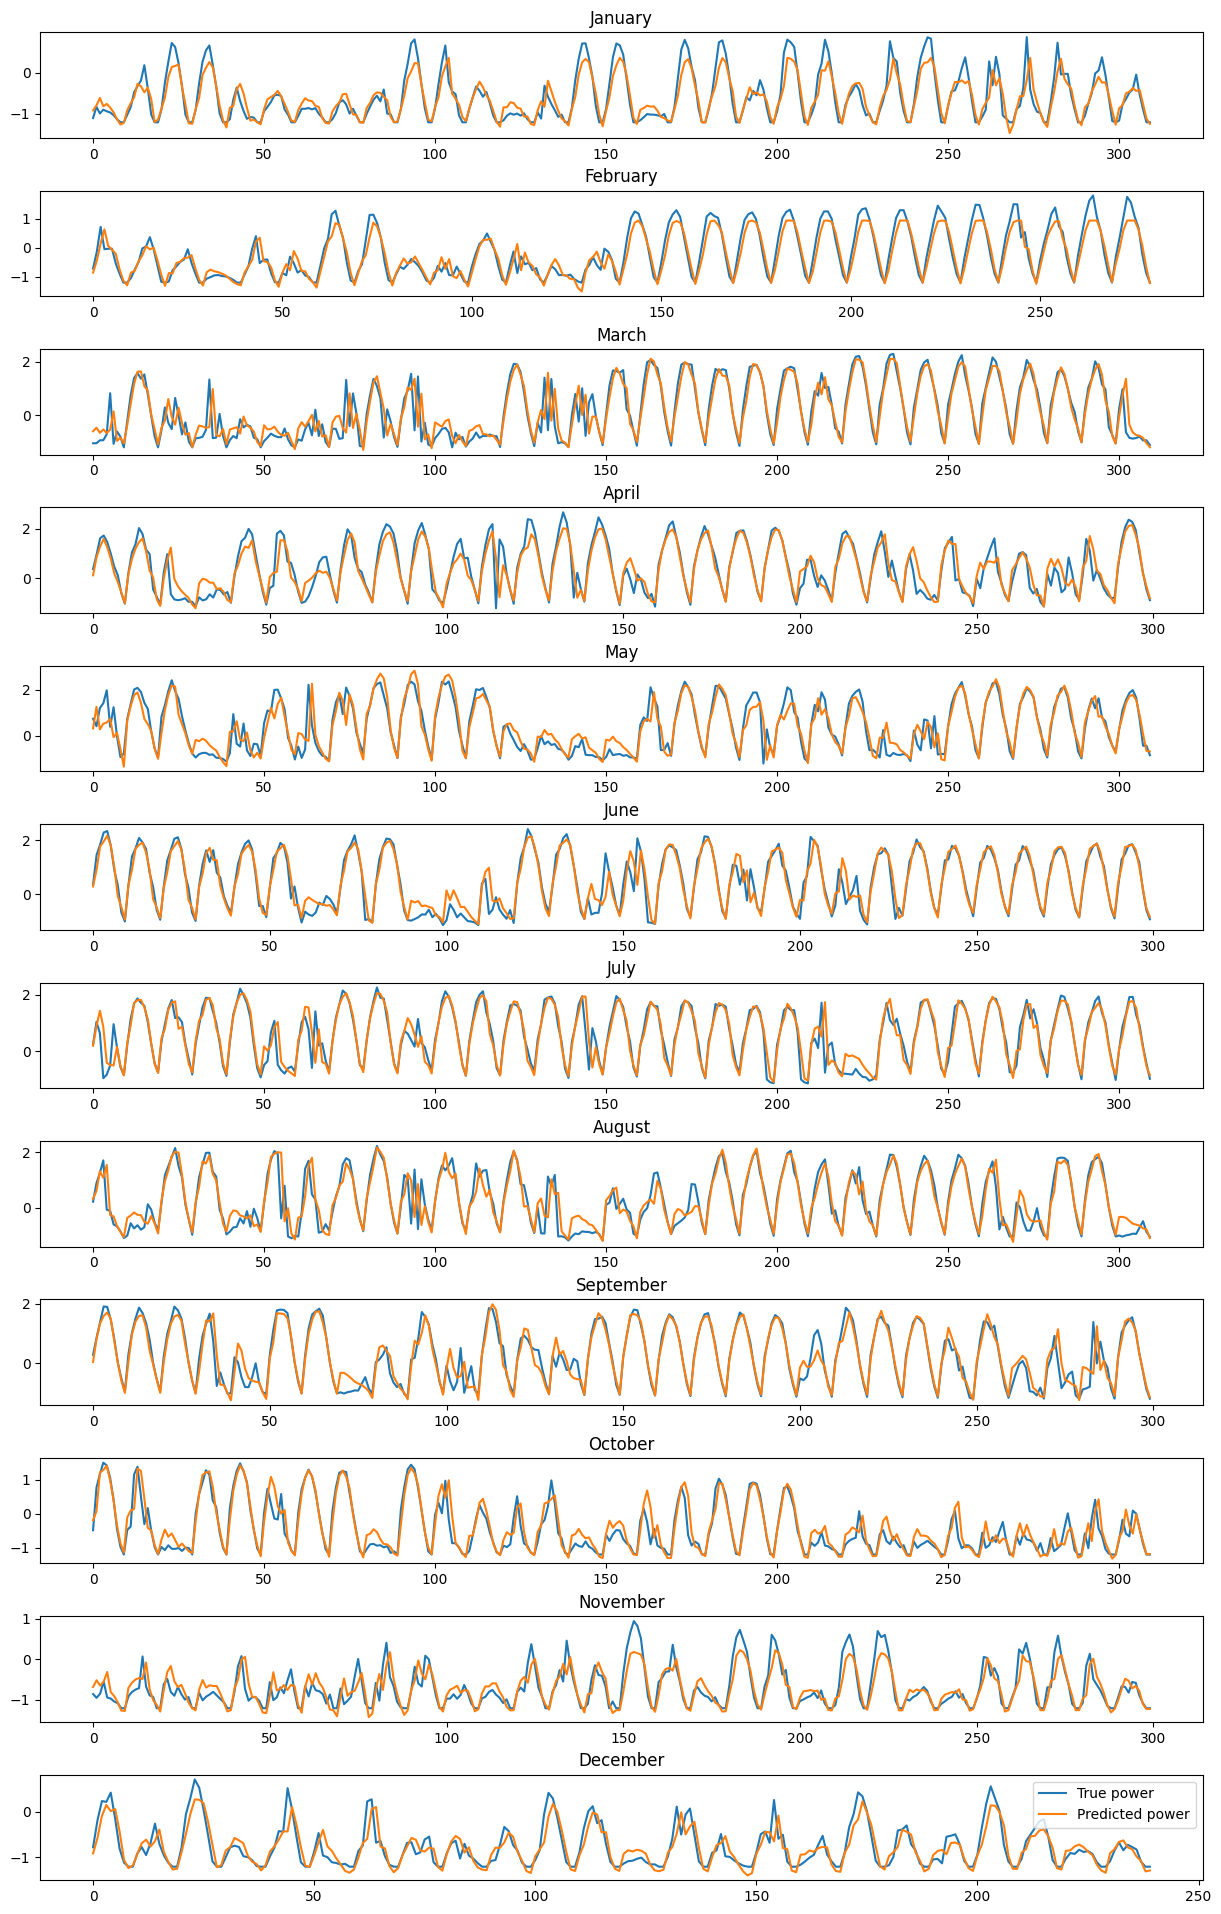

In [20]:
# Compare the prediction with the true value for each month
plt.figure(figsize=(15, 2*len(nbr_values_per_month)))
plt.subplots_adjust(hspace=0.5)
for ind, row in nbr_values_per_month.iterrows():
    y_valid_month = y_valid[ind]
    outs_valid_month = outs_valid[ind]
    plt.subplot(len(nbr_values_per_month), 1, ind+1)
    plt.plot(y_valid_month, label='True power')
    plt.plot(outs_valid_month, label='Predicted power')
    plt.title(months_name[row.month])
plt.legend()
plt.show()

> Similar results, but the model is less likely to overfit, since it only has one month of data.

### 3. Streaming model, shifting window

> Train a model using a week of data, predict the same week of the next year. Shift the window one day at a time and average the results for the same days. 

In [21]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [22]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [23]:
# Filter with months 7, 8, 9
selected_months = [7, 8, 9]

months_idx_begin = nbr_values_per_month.time[0:selected_months[0]-1].sum()
months_idx_end = nbr_values_per_month.time[0:selected_months[-1]].sum()

x_train = x_train[months_idx_begin:months_idx_end, :]
y_train = y_train[months_idx_begin:months_idx_end]

x_valid = x_valid[months_idx_begin:months_idx_end, :]
y_valid = y_valid[months_idx_begin:months_idx_end]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((920, 10), (920, 1), (920, 10), (920, 1))

In [24]:
TOTAL_TRAIN_SAMPLES = len(x_train)
WINDOW_SIZE = 7*(hour_end-hour_begin) # window of 7 days

N_ARRIVALS_PER_ROUND = 1*(hour_end-hour_begin) # shift by 1 day

TIME_HORIZON = int((TOTAL_TRAIN_SAMPLES-WINDOW_SIZE)/N_ARRIVALS_PER_ROUND)

NUM_EPOCHS = 300

LR_GRID = [1e-2]
SEED_GRID = [1956]

SAVE_PATH = 'scenario3.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [25]:
all_results_dict = dict()

for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)
        
        start_index = 0

        for step in tqdm(range(1, TIME_HORIZON+1)):
            all_results_dict[seed_][lr_][step] = dict()
            # Get the current window of data
            x_train_window = x_train[start_index:start_index+WINDOW_SIZE, :]
            y_train_window = y_train[start_index:start_index+WINDOW_SIZE]
            
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_window), torch.tensor(y_train_window))
            train_dataloader = DataLoader(train_dataset, batch_size=WINDOW_SIZE, shuffle=True)
            train_iterator = iter(train_dataloader)
            
            # Create the model, optimizer, and trainer
            model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)
            
            training_loss_history = []

            optimizer = optim.SGD(
                [param for param in model.parameters() if param.requires_grad],
                lr=lr_,
                momentum=0.9,
                weight_decay=5e-4
            )

            trainer = Trainer(
                model=model,
                criterion=nn.MSELoss(reduction='none').to(DEVICE),
                metric=mse,
                device=DEVICE,
                optimizer=optimizer,
                cast_label=False,
            )
            
            for epoch in range(NUM_EPOCHS):
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                ## Training Loss
                try:
                    x_stream, y_stream = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_stream, y_stream = next(train_iterator)
            
                x_stream = x_stream.to(DEVICE).type(torch.float32)
                y_stream = y_stream.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_stream = trainer.model(x_stream)
                loss_stream = trainer.criterion(outs_stream, y_stream).mean()
                loss = loss_stream
                
                training_loss_history.append(loss_stream.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                # print(f"Step: {step} | Epoch: {epoch} | Training Loss: {loss:0.3f}")
                
            # Predict the values
            x_valid_window = torch.tensor(x_valid[start_index:start_index+WINDOW_SIZE, :]).to(DEVICE).type(torch.float32)
            y_valid_window = torch.tensor(y_valid[start_index:start_index+WINDOW_SIZE]).to(DEVICE).type(torch.float32)
            
            outs_valid_window = trainer.model(x_valid_window)
            
            # Compute prediction loss
            loss_pred = trainer.criterion(outs_valid_window, y_valid_window).mean()
            
            # Update the start index
            start_index += N_ARRIVALS_PER_ROUND
            
            # save the results
            all_results_dict[seed_][lr_][step] = {'training_loss': training_loss_history,
                                                  'prediction_loss': loss_pred.detach().cpu().numpy().tolist(),
                                                  'outs_valid': outs_valid_window.detach().cpu().numpy(),
                                                  'y_valid': y_valid_window.detach().cpu().numpy()}
            
        
        # Save the results in a json file
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())

100%|██████████| 85/85 [00:09<00:00,  9.11it/s]


In [26]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

# convert this a df with the columns seed, lr, step, training_loss, prediction_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'step', 'training_loss', 'prediction_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        for step in all_results_dict[seed][lr].keys():
            df = df.append({'seed': seed,
                            'lr': lr,
                            'step': step,
                            'training_loss': all_results_dict[seed][lr][step]['training_loss'],
                            'prediction_loss': all_results_dict[seed][lr][step]['prediction_loss'],
                            'outs_valid': all_results_dict[seed][lr][step]['outs_valid'],
                            'y_valid': all_results_dict[seed][lr][step]['y_valid']}, ignore_index=True)
        
df.head(3)

,seed,lr,step,training_loss,prediction_loss,outs_valid,y_valid
0,1956,0.01,1,"[0.8755566477775574, 0.8530392050743103, 0.811...",0.315662,"[[0.4392712712287903], [1.1146199703216553], [...","[[0.1465112864971161], [1.1056119203567505], [..."
1,1956,0.01,2,"[0.7657623291015625, 0.7503838539123535, 0.722...",0.271209,"[[0.21436096727848053], [0.8882768154144287], ...","[[0.2148619145154953], [0.9398062229156494], [..."
2,1956,0.01,3,"[1.5891684293746948, 1.490900993347168, 1.3108...",0.266024,"[[-0.05314144492149353], [0.32901665568351746]...","[[0.0007940557552501559], [-0.5036489367485046..."


In [27]:
seed = '1956'
lr = '0.01'

outs_valid = df[(df.seed == seed) & (df.lr == lr)]['outs_valid'].values
y_valid_values = df[(df.seed == seed) & (df.lr == lr)]['y_valid'].values

In [28]:
outs_valid = np.array(outs_valid.tolist()).reshape(-1, WINDOW_SIZE)
outs_valid

array([[ 0.43927127,  1.11461997,  1.72673774, ...,  0.17152774,
        -0.50263023, -0.58478415],
       [ 0.21436097,  0.88827682,  1.54841101, ...,  0.23093647,
        -0.56200147, -0.98573464],
       [-0.05314144,  0.32901666,  0.49869958, ...,  0.1587401 ,
        -0.49924648, -0.69769728],
       ...,
       [ 0.01135078,  0.60066396,  1.01605248, ..., -0.39217395,
        -0.87975591, -1.20955229],
       [-0.0053578 ,  0.4617148 ,  1.2000953 , ..., -0.30629799,
        -0.79733527, -1.21065152],
       [ 0.02423197,  0.49832544,  1.1607132 , ..., -0.40132183,
        -0.86432648, -1.27580702]])

In [29]:
y_final = np.full((outs_valid.shape[0], 910), np.nan)

# for each row of outs_valid, fill the corresponding row of y_final shifting by 10 columns each time
for i in range(outs_valid.shape[0]):
    y_final[i, i*(hour_end-hour_begin):i*(hour_end-hour_begin)+WINDOW_SIZE] = outs_valid[i]

In [30]:
y_final_df = pd.DataFrame(y_final)
y_final_df.shape

(85, 910)

In [31]:
y_final_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909
0,0.439271,1.11462,1.726738,1.886625,1.880151,1.614727,0.967724,-0.040971,-0.481382,-0.618019,0.453121,0.991882,1.612893,1.904107,1.767236,1.391154,0.964317,0.167549,-0.513266,-0.713000,-0.138556,0.525805,0.806486,0.951502,0.624809,1.357886,0.161101,-0.582173,-0.390812,-0.633846,0.174746,0.923670,1.596676,1.846679,1.001962,0.983292,-0.295138,-0.619637,-0.435273,-0.717711,0.389003,0.914329,1.568214,1.766176,1.755322,1.589907,0.849456,0.001340,-0.605396,-0.872618,-0.

In [32]:
# compute the mean and std of each column
y_final_mean = y_final_df.mean(axis=0)
y_final_std = y_final_df.std(axis=0)

In [33]:
loss = np.mean((y_final_mean - y_valid[0:910].flatten())**2)
loss

0.17495216399425137

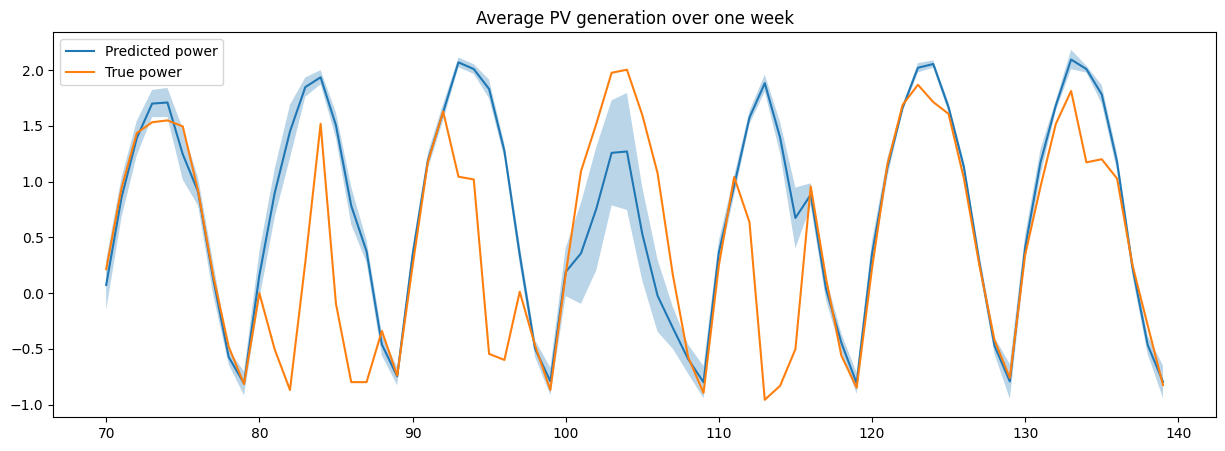

In [34]:
# plot the mean and std using fill_between of the first 70 columns
plt.figure(figsize=(15, 5))
plt.plot(y_final_mean[70:140], label='Predicted power')
plt.fill_between(np.arange(70, 140), y_final_mean[70:140] - y_final_std[70:140], y_final_mean[70:140] + y_final_std[70:140], alpha=0.3)
plt.plot(np.arange(70, 140),y_valid_values[1], label='True power')
plt.title('Average PV generation over one week')
plt.legend()
plt.show()

> This experiement makes less sense, we compare the online method using a week of data with the offline method using a month of data.

### 4. Train 01.2018 -> predict each month of 2018 with this model

> Train a model using 01.2018, predict each month of 2018 with this model.

In [35]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)

# Change validation year to 2018 as well
x_valid = x_train
y_valid = y_train

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [36]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [37]:
# Change x_train and y_train to be only one month of the year
training_month = 1

# get starting and ending idx using nbr_values_per_month
month_idx_begin = nbr_values_per_month.time[0:training_month-1].sum()
month_idx_end = nbr_values_per_month.time[0:training_month].sum()

x_train = x_train[month_idx_begin:month_idx_end, :]
y_train = y_train[month_idx_begin:month_idx_end]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((310, 10), (310, 1), (3650, 10), (3650, 1))

In [38]:
NUM_EPOCHS = 300

LOG_FREQ = 50

LR_GRID = [1e-3, 1e-2, 1e-1]
SEED_GRID = [1956]

SAVE_PATH = 'scenario4.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [39]:
# Run experiments

all_results_dict = dict()
for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        
        ###### Print current seed and lr
        print(f"\nSeed: {seed_} | LR: {lr_}")
        
        ###### Define the model, optimizer, loss function and history
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)

        # Create the model, optimizer, and trainer
        model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)

        optimizer = optim.SGD(
            [param for param in model.parameters() if param.requires_grad],
            lr=lr_,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainer = Trainer(
            model=model,
            criterion=nn.MSELoss(reduction='none').to(DEVICE),
            metric=mse,
            device=DEVICE,
            optimizer=optimizer,
            cast_label=False,
        )
        
        ###### Define training data
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
        train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        train_iterator = iter(train_dataloader)
        
        ###### Training loop
        training_loss_history = []
        for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
        
            # Clear gradients from the previous iteration
            trainer.optimizer.zero_grad()

            # Get next batch of data
            try:
                x_stream, y_stream = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_dataloader)
                x_stream, y_stream = next(train_iterator)
            x_stream = x_stream.to(DEVICE).type(torch.float32)
            y_stream = y_stream.to(DEVICE).type(torch.float32)

            # Forward pass
            outs_stream = trainer.model(x_stream)
            loss_stream = trainer.criterion(outs_stream, y_stream).mean()
            
            # Store loss value
            training_loss_history.append(loss_stream.detach().cpu().numpy())
        
            # Get gradients w.r.t to parameters
            loss_stream.backward()
            
            # Update the parameters
            trainer.optimizer.step()
            
            # # Print loss value
            # if epoch % LOG_FREQ == 0:
            #     tqdm.write(f"Epoch: {epoch} | Training Loss: {loss_stream:0.3f}")
        
        # Print training loss value
        print(f'Training Loss: {loss_stream:0.3f}')
        
        ###### Test the model
        outs_valid = trainer.model(torch.tensor(x_valid).to(DEVICE).type(torch.float32))
        loss_valid = trainer.criterion(outs_valid, torch.tensor(y_valid).to(DEVICE).type(torch.float32)).mean()
        
        print(f"Validation Loss: {loss_valid:0.3f}")
        
        # Save the results in a json file
        all_results_dict[seed_][lr_] = {'training_loss': training_loss_history,
                                        'validation_loss': loss_valid.detach().cpu().numpy(),
                                        'outs_valid': outs_valid.detach().cpu().numpy(),
                                        'y_valid': y_valid}
        
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())


Seed: 1956 | LR: 0.001


100%|██████████| 300/300 [00:00<00:00, 845.39it/s]


Training Loss: 0.101
Validation Loss: 0.621

Seed: 1956 | LR: 0.01


100%|██████████| 300/300 [00:00<00:00, 731.28it/s]


Training Loss: 0.069
Validation Loss: 0.450

Seed: 1956 | LR: 0.1


100%|██████████| 300/300 [00:00<00:00, 895.52it/s]

Training Loss: 0.051
Validation Loss: 10.027


In [40]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

all_results_dict
# convert this a df with the columns seed, lr, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'training_loss', 'validation_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        df = df.append({'seed': seed,
                        'lr': lr,
                        'training_loss': all_results_dict[seed][lr]['training_loss'],
                        'validation_loss': all_results_dict[seed][lr]['validation_loss'],
                        'outs_valid': all_results_dict[seed][lr]['outs_valid'],
                        'y_valid': all_results_dict[seed][lr]['y_valid']}, ignore_index=True)
        
df

,seed,lr,training_loss,validation_loss,outs_valid,y_valid
0,1956,0.001,"[1.1936070919036865, 1.176383376121521, 1.1442...",0.621046,"[[-1.0144869089126587], [-0.735378623008728], ...","[[-1.0896543873179176], [-0.4140324839518368],..."
1,1956,0.01,"[1.1936070919036865, 1.028059482574463, 0.7648...",0.449820,"[[-0.851765513420105], [-0.8073062896728516], ...","[[-1.0896543873179176], [-0.4140324839518368],..."
2,1956,0.1,"[1.1936070919036865, 0.20639608800411224, 0.81...",10.026895,"[[-0.886846661567688], [-0.8382240533828735], ...","[[-1.0896543873179176], [-0.4140324839518368],..."


In [41]:
seed = '1956'
lr = '0.01'

outs_valid_values = df[(df.seed == seed) & (df.lr == lr)]['outs_valid'].values
y_valid_values = df[(df.seed == seed) & (df.lr == lr)]['y_valid'].values

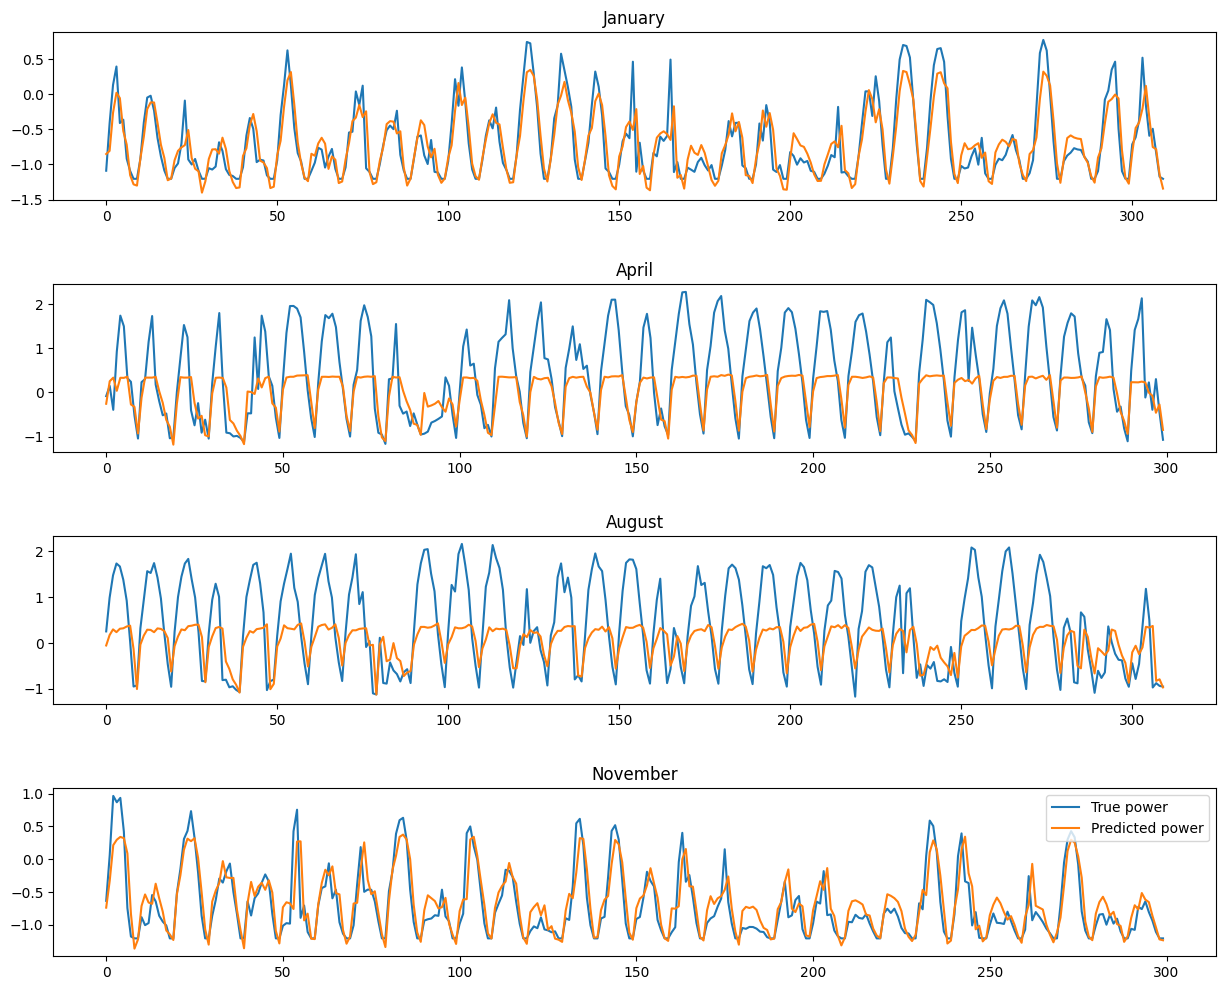

In [42]:
months_to_plot = [1, 4, 8, 11]

plt.figure(figsize=(15, 3*len(months_to_plot)))
plt.subplots_adjust(hspace=0.5)

for ind, month_to_plot in enumerate(months_to_plot):
    month_idx_begin = nbr_values_per_month.time[0:month_to_plot-1].sum()
    month_idx_end = nbr_values_per_month.time[0:month_to_plot].sum()

    plt.subplot(len(months_to_plot), 1, ind+1)
    plt.plot(y_valid_values[0][month_idx_begin:month_idx_end], label='True power')
    plt.plot(outs_valid_values[0][month_idx_begin:month_idx_end], label='Predicted power')
    plt.title(months_name[month_to_plot])
    
plt.legend()
plt.show()

# month_idx_begin = nbr_values_per_month.time[0:month_to_plot-1].sum()
# month_idx_end = nbr_values_per_month.time[0:month_to_plot].sum()

# plt.figure(figsize=(15, 5))
# plt.plot(y_valid_values[0][month_idx_begin:month_idx_end], label='True power')
# plt.plot(outs_valid_values[0][month_idx_begin:month_idx_end], label='Predicted power')
# plt.title(months_name[month_to_plot])
# plt.legend(loc='best')
# plt.show()

In [43]:
# Print the validation loss for each month
validation_loss = []
for month in range(1, 13):
    month_idx_begin = nbr_values_per_month.time[0:month-1].sum()
    month_idx_end = nbr_values_per_month.time[0:month].sum()
    
    loss = np.mean((np.array(y_valid_values[0][month_idx_begin:month_idx_end]) - np.array(outs_valid_values[0][month_idx_begin:month_idx_end]))**2)
    validation_loss.append(loss)
    
    print(f'{months_name[month]} - Validation Loss: {loss:0.3f}')

January - Validation Loss: 0.069
February - Validation Loss: 0.166
March - Validation Loss: 0.332
April - Validation Loss: 0.683
May - Validation Loss: 0.663
June - Validation Loss: 0.922
July - Validation Loss: 0.872
August - Validation Loss: 0.707
September - Validation Loss: 0.582
October - Validation Loss: 0.263
November - Validation Loss: 0.078
December - Validation Loss: 0.048


> Since we train using a winter month, the predictions are not good for summer months. The model is not able to predict the higher values of summer months.

### 5. Train 01.2018 -> predict 02.2018, add 02.2018 to the training set -> predict 03.2018 ...

> To take into account the new data, we add the month to the training set and keep the old months (increasing the training set size at the end of each month). We predict the following month with the model trained on the previous months.

In [44]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)

# Change validation year to 2018 as well
x_valid = x_train
y_valid = y_train

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [45]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [46]:
NUM_EPOCHS = 300

LOG_FREQ = 50

LR_GRID = [1e-3, 1e-2, 1e-1]
SEED_GRID = [1956]

SAVE_PATH = 'scenario5.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [47]:
# Run experiments

all_results_dict = dict()
for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        
        ###### Print current seed and lr
        print(f"\nSeed: {seed_} | LR: {lr_}")
        
        ###### Define the model, optimizer, loss function and history
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)

        # Create the model, optimizer, and trainer
        model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)

        optimizer = optim.SGD(
            [param for param in model.parameters() if param.requires_grad],
            lr=lr_,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainer = Trainer(
            model=model,
            criterion=nn.MSELoss(reduction='none').to(DEVICE),
            metric=mse,
            device=DEVICE,
            optimizer=optimizer,
            cast_label=False,
        )
        
        # loop over the months to use as training data
        for month in range(1,12):
        
            all_results_dict[seed_][lr_][months_name[month]] = dict()
        
            ###### Define training data
            month_idx_begin = nbr_values_per_month.time[0:month-1].sum()
            month_idx_end = nbr_values_per_month.time[0:month].sum()
            
            x_train_month = x_train[0:month_idx_end, :]
            y_train_month = y_train[0:month_idx_end]
        
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
            train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
            train_iterator = iter(train_dataloader)
        
            ###### Training loop
            training_loss_history = []
            for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
            
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                # Get next batch of data
                try:
                    x_stream, y_stream = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_stream, y_stream = next(train_iterator)
                x_stream = x_stream.to(DEVICE).type(torch.float32)
                y_stream = y_stream.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_stream = trainer.model(x_stream)
                loss_stream = trainer.criterion(outs_stream, y_stream).mean()
                
                # Store loss value
                training_loss_history.append(loss_stream.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss_stream.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                
                # # Print loss value
                # if epoch % LOG_FREQ == 0:
                #     tqdm.write(f"Epoch: {epoch} | Training Loss: {loss_stream:0.3f}")
        
            # Print training loss value
            print(f'Training Loss: {loss_stream:0.3f}')
        
            ###### Test the model on the next month
            month_idx_begin = nbr_values_per_month.time[0:month].sum()
            month_idx_end = nbr_values_per_month.time[0:month+1].sum()
            
            x_valid_month = x_valid[month_idx_begin:month_idx_end, :]
            y_valid_month = y_valid[month_idx_begin:month_idx_end]
            
            outs_valid_month = trainer.model(torch.tensor(x_valid_month).to(DEVICE).type(torch.float32))
            loss_valid_month = trainer.criterion(outs_valid_month, torch.tensor(y_valid_month).to(DEVICE).type(torch.float32)).mean()
        
            print(f"Validation Loss: {loss_valid_month:0.3f}")
        
            # Save the results in a json file
            all_results_dict[seed_][lr_][months_name[month]] = {'training_loss': training_loss_history,
                                            'validation_loss': loss_valid_month.detach().cpu().numpy(),
                                            'outs_valid': outs_valid_month.detach().cpu().numpy(),
                                            'y_valid': y_valid_month}
            
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())


Seed: 1956 | LR: 0.001


100%|██████████| 300/300 [00:00<00:00, 849.69it/s]


Training Loss: 0.101
Validation Loss: 0.255


100%|██████████| 300/300 [00:00<00:00, 937.26it/s]


Training Loss: 0.102
Validation Loss: 0.340


100%|██████████| 300/300 [00:00<00:00, 621.82it/s]


Training Loss: 0.156
Validation Loss: 0.473


100%|██████████| 300/300 [00:00<00:00, 617.52it/s]


Training Loss: 0.148
Validation Loss: 0.431


100%|██████████| 300/300 [00:00<00:00, 565.64it/s]


Training Loss: 0.180
Validation Loss: 0.306


100%|██████████| 300/300 [00:00<00:00, 615.06it/s]


Training Loss: 0.146
Validation Loss: 0.161


100%|██████████| 300/300 [00:00<00:00, 751.02it/s]


Training Loss: 0.086
Validation Loss: 0.170


100%|██████████| 300/300 [00:00<00:00, 579.32it/s]


Training Loss: 0.158
Validation Loss: 0.103


100%|██████████| 300/300 [00:00<00:00, 702.11it/s]


Training Loss: 0.155
Validation Loss: 0.087


100%|██████████| 300/300 [00:00<00:00, 610.60it/s]


Training Loss: 0.125
Validation Loss: 0.074


100%|██████████| 300/300 [00:00<00:00, 589.50it/s]


Training Loss: 0.092
Validation Loss: 0.045

Seed: 1956 | LR: 0.01


100%|██████████| 300/300 [00:00<00:00, 953.70it/s]


Training Loss: 0.069
Validation Loss: 0.166


100%|██████████| 300/300 [00:00<00:00, 999.80it/s]


Training Loss: 0.077
Validation Loss: 0.177


100%|██████████| 300/300 [00:00<00:00, 615.41it/s]


Training Loss: 0.092
Validation Loss: 0.244


100%|██████████| 300/300 [00:00<00:00, 764.59it/s]


Training Loss: 0.113
Validation Loss: 0.279


100%|██████████| 300/300 [00:00<00:00, 576.89it/s]


Training Loss: 0.144
Validation Loss: 0.108


100%|██████████| 300/300 [00:00<00:00, 559.89it/s]


Training Loss: 0.106
Validation Loss: 0.094


100%|██████████| 300/300 [00:00<00:00, 767.37it/s]


Training Loss: 0.050
Validation Loss: 0.142


100%|██████████| 300/300 [00:00<00:00, 687.60it/s]


Training Loss: 0.135
Validation Loss: 0.082


100%|██████████| 300/300 [00:00<00:00, 518.49it/s]


Training Loss: 0.132
Validation Loss: 0.079


100%|██████████| 300/300 [00:00<00:00, 541.88it/s]


Training Loss: 0.105
Validation Loss: 0.071


100%|██████████| 300/300 [00:00<00:00, 682.96it/s]


Training Loss: 0.084
Validation Loss: 0.040

Seed: 1956 | LR: 0.1


100%|██████████| 300/300 [00:00<00:00, 993.34it/s]


Training Loss: 0.051
Validation Loss: 0.199


100%|██████████| 300/300 [00:00<00:00, 903.17it/s] 


Training Loss: 0.067
Validation Loss: 0.233


100%|██████████| 300/300 [00:00<00:00, 725.05it/s]


Training Loss: 0.085
Validation Loss: 0.205


100%|██████████| 300/300 [00:00<00:00, 719.78it/s]


Training Loss: 0.107
Validation Loss: 0.274


100%|██████████| 300/300 [00:00<00:00, 672.79it/s]


Training Loss: 0.135
Validation Loss: 0.210


100%|██████████| 300/300 [00:00<00:00, 659.27it/s]


Training Loss: 0.105
Validation Loss: 0.120


100%|██████████| 300/300 [00:00<00:00, 779.50it/s]


Training Loss: 0.062
Validation Loss: 0.144


100%|██████████| 300/300 [00:00<00:00, 603.54it/s]


Training Loss: 0.132
Validation Loss: 0.082


100%|██████████| 300/300 [00:00<00:00, 627.58it/s]


Training Loss: 0.140
Validation Loss: 0.087


100%|██████████| 300/300 [00:00<00:00, 643.13it/s]


Training Loss: 0.110
Validation Loss: 0.065


100%|██████████| 300/300 [00:00<00:00, 628.71it/s]

Training Loss: 0.083
Validation Loss: 0.044


In [48]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

all_results_dict
# convert this a df with the columns seed, lr, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'month', 'training_loss', 'validation_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        for month in all_results_dict[seed][lr].keys():
            df = df.append({'seed': seed,
                            'lr': lr,
                            'month': month,
                            'training_loss': all_results_dict[seed][lr][month]['training_loss'],
                            'validation_loss': all_results_dict[seed][lr][month]['validation_loss'],
                            'outs_valid': all_results_dict[seed][lr][month]['outs_valid'],
                            'y_valid': all_results_dict[seed][lr][month]['y_valid']}, 
                           ignore_index=True)
        
df

,seed,lr,month,training_loss,validation_loss,outs_valid,y_valid
0,1956,0.001,January,"[1.1936070919036865, 1.176383376121521, 1.1442...",0.254780,"[[-0.8748708963394165], [-0.6417772769927979],...","[[-1.066486197533279], [-1.0434241468061336], ..."
1,1956,0.001,February,"[0.17696869373321533, 0.15551802515983582, 0.1...",0.339953,"[[-0.7057445645332336], [-0.6113263368606567],...","[[-1.0866676295728117], [-0.7341653069169998],..."
2,1956,0.001,March,"[0.18832805752754211, 0.21311651170253754, 0.2...",0.473314,"[[-0.23227828741073608], [0.3041614294052124],...","[[-0.08453181596339586], [0.14740213582951875]..."
3,1956,0.001,April,"[0.23883768916130066, 0.2311958521604538, 0.23...",0.431000,"[[0.02409195899963379], [0.5075863599777222], ...","[[-0.27405584839717806], [-0.12661805666134368..."
4,1956,0.001,May,"[0.22876547276973724, 0.2028369903564453, 0.24...",0.306408,"[[0.6701911687850952], [1.1624670028686523], [...","[[0.37458252238255524], [1.307400052005948], [..."
5,1956,0.001,June,"[0.2154688537120819, 0.1859520673751831, 0.195...",0.161454,"[[0.3587643504142761], [0.9397562742233276], [...","[[0.21976605047377762], [1.0698581754029195], ..."
6,1956,0.001,July,"[0.19082851707935333, 0.16486157476902008, 0.1...",0.169920,"[[0.15733301639556885], [0.9319720268249512], ...","[[0.25253082546447003], [0.9877391791081245], ..."
7,1956,0.001,August,"[0.12865230441093445, 0.1396821141242981, 0.13...",0.103260,"[[-0.23047727346420288], [0.2606375217437744],...","[[-0.26034004564389646], [-0.7430384222044641]..."
8,1956,0.001,September,"[0.14051200449466705, 0.14215543866157532, 0.1...",0.087129,"[[-0.4602006673812866], [-0.13569438457489014]...","[[-0.6242004543206185], [-0.6924911299286077],..."
9,1956,0.001,October,"[0.12398704886436462, 0.11241015791893005, 0.1...",0.073830,"[[-0.649499773979187], [-0.2673187255859375], ...","[[-0.6334933864257362], [0.0634945439824893], ..."


In [49]:
df.groupby(['seed', 'lr'])['validation_loss'].mean()

seed  lr   
1956  0.001    0.222376
      0.01     0.134720
      0.1      0.151138
Name: validation_loss, dtype: float64

In [50]:
seed = '1956'
lr = '0.01'

df = df[(df.seed == seed) & (df.lr == lr)]
df

,seed,lr,month,training_loss,validation_loss,outs_valid,y_valid
11,1956,0.01,January,"[1.1936070919036865, 1.028059482574463, 0.7648...",0.166112,"[[-0.8957517147064209], [-0.7701802253723145],...","[[-1.066486197533279], [-1.0434241468061336], ..."
12,1956,0.01,February,"[0.11739770323038101, 0.0984221026301384, 0.10...",0.176920,"[[-0.7937889099121094], [-0.7702538967132568],...","[[-1.0866676295728117], [-0.7341653069169998],..."
13,1956,0.01,March,"[0.10305532813072205, 0.12275483459234238, 0.1...",0.243839,"[[-0.3224923610687256], [0.3264751434326172], ...","[[-0.08453181596339586], [0.14740213582951875]..."
14,1956,0.01,April,"[0.13530868291854858, 0.13052873313426971, 0.1...",0.278944,"[[-0.3188321590423584], [0.16984891891479492],...","[[-0.27405584839717806], [-0.12661805666134368..."
15,1956,0.01,May,"[0.15399445593357086, 0.13529224693775177, 0.1...",0.108413,"[[0.38382965326309204], [1.0427632331848145], ...","[[0.37458252238255524], [1.307400052005948], [..."
16,1956,0.01,June,"[0.13371099531650543, 0.11496903002262115, 0.1...",0.093807,"[[0.2073272466659546], [1.0533044338226318], [...","[[0.21976605047377762], [1.0698581754029195], ..."
17,1956,0.01,July,"[0.1374426931142807, 0.13272207975387573, 0.08...",0.141736,"[[0.22620916366577148], [0.9959021806716919], ...","[[0.25253082546447003], [0.9877391791081245], ..."
18,1956,0.01,August,"[0.10643027722835541, 0.12013125419616699, 0.1...",0.082252,"[[-0.31354475021362305], [0.13273990154266357]...","[[-0.26034004564389646], [-0.7430384222044641]..."
19,1956,0.01,September,"[0.1243603453040123, 0.12289875745773315, 0.10...",0.078572,"[[-0.5135586261749268], [-0.21232330799102783]...","[[-0.6242004543206185], [-0.6924911299286077],..."
20,1956,0.01,October,"[0.11528743803501129, 0.1040034219622612, 0.10...",0.071055,"[[-0.6842519044876099], [-0.2652090787887573],...","[[-0.6334933864257362], [0.0634945439824893], ..."


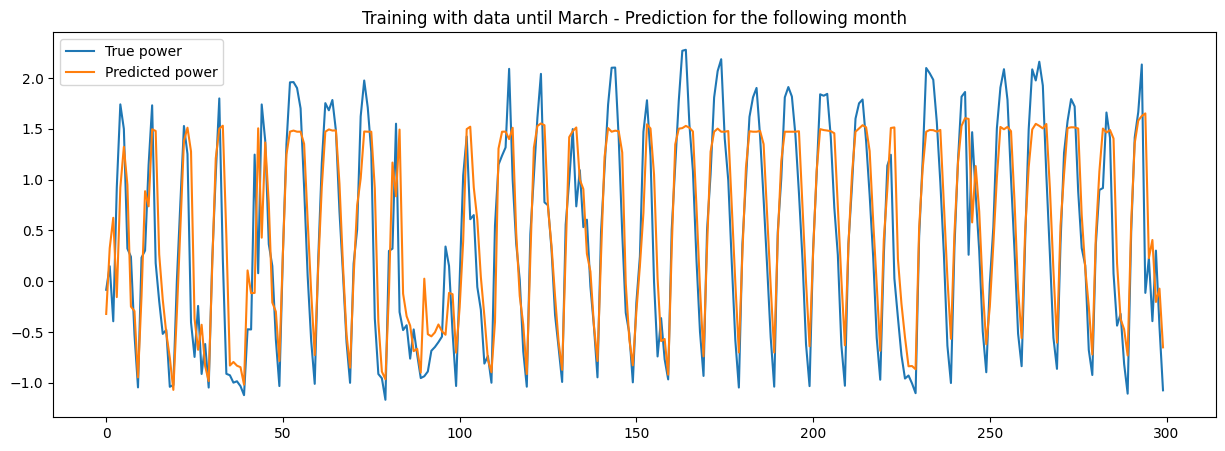

In [51]:
# month until which the model was trained, we predict (and plot) the power for the following month
month = 'March'

outs_valid_values = df[df.month == month]['outs_valid'].values[0]
y_valid_values = df[df.month == month]['y_valid'].values[0]

plt.figure(figsize=(15, 5))
plt.plot(y_valid_values, label='True power')
plt.plot(outs_valid_values, label='Predicted power')
plt.title(f'Training with data until {month} - Prediction for the following month')
plt.legend(loc='best')
plt.show()

> The results are not very good in the first few months, once we have increased the training set the results are better. Same conclusion as the first experiments, the model probably overfits and predicts using a similar day from the previous months. 

### 6. Train 01.2018 -> predict 02.2018, train 02.2018 -> predict 03.2018 ...

> We train a model for each month and predict the following month of the same year.

In [52]:
x_train, y_train, x_valid, y_valid = access_data(env_dict, client_id=0)

# Change validation year to 2018 as well
x_valid = x_train
y_valid = y_train

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3650, 10), (3650, 1), (3650, 10), (3650, 1))

In [53]:
nbr_values_per_month = get_nbr_values_per_month(env_dict)
nbr_values_per_month

,month,time
0,1,310
1,2,280
2,3,310
3,4,300
4,5,310
5,6,300
6,7,310
7,8,310
8,9,300
9,10,310


In [54]:
NUM_EPOCHS = 300

LOG_FREQ = 50

LR_GRID = [1e-3, 1e-2, 1e-1]
SEED_GRID = [1956]

SAVE_PATH = 'scenario6.json'

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
# DEVICE = 'mps'

print("DEVICE:", DEVICE)

DEVICE: cpu


In [55]:
# Run experiments

all_results_dict = dict()
for seed_ in SEED_GRID:
    all_results_dict[seed_] = dict()
    for lr_ in LR_GRID:
        all_results_dict[seed_][lr_] = dict()
        
        ###### Print current seed and lr
        print(f"\nSeed: {seed_} | LR: {lr_}")
        
        ###### Define the model, optimizer, loss function and history
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        torch.manual_seed(seed_)

        # Create the model, optimizer, and trainer
        model = SimpleNN(input_dim=x_train.shape[1], output_dim=1, hidden_dim=5).to(DEVICE)

        optimizer = optim.SGD(
            [param for param in model.parameters() if param.requires_grad],
            lr=lr_,
            momentum=0.9,
            weight_decay=5e-4
        )

        trainer = Trainer(
            model=model,
            criterion=nn.MSELoss(reduction='none').to(DEVICE),
            metric=mse,
            device=DEVICE,
            optimizer=optimizer,
            cast_label=False,
        )
        
        # loop over the months to use as training data
        for month in range(1,12):
        
            all_results_dict[seed_][lr_][months_name[month]] = dict()
        
            ###### Define training data
            month_idx_begin = nbr_values_per_month.time[0:month-1].sum()
            month_idx_end = nbr_values_per_month.time[0:month].sum()
            
            x_train_month = x_train[month_idx_begin:month_idx_end, :]
            y_train_month = y_train[month_idx_begin:month_idx_end]
        
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_month), torch.tensor(y_train_month))
            train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
            train_iterator = iter(train_dataloader)
        
            ###### Training loop
            training_loss_history = []
            for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
            
                # Clear gradients from the previous iteration
                trainer.optimizer.zero_grad()

                # Get next batch of data
                try:
                    x_stream, y_stream = next(train_iterator)
                except StopIteration:
                    train_iterator = iter(train_dataloader)
                    x_stream, y_stream = next(train_iterator)
                x_stream = x_stream.to(DEVICE).type(torch.float32)
                y_stream = y_stream.to(DEVICE).type(torch.float32)

                # Forward pass
                outs_stream = trainer.model(x_stream)
                loss_stream = trainer.criterion(outs_stream, y_stream).mean()
                
                # Store loss value
                training_loss_history.append(loss_stream.detach().cpu().numpy())
            
                # Get gradients w.r.t to parameters
                loss_stream.backward()
                
                # Update the parameters
                trainer.optimizer.step()
                
                # # Print loss value
                # if epoch % LOG_FREQ == 0:
                #     tqdm.write(f"Epoch: {epoch} | Training Loss: {loss_stream:0.3f}")
        
            # Print training loss value
            print(f'Training Loss: {loss_stream:0.3f}')
        
            ###### Test the model on the next month
            month_idx_begin = nbr_values_per_month.time[0:month].sum()
            month_idx_end = nbr_values_per_month.time[0:month+1].sum()
            
            x_valid_month = x_valid[month_idx_begin:month_idx_end, :]
            y_valid_month = y_valid[month_idx_begin:month_idx_end]
            
            outs_valid_month = trainer.model(torch.tensor(x_valid_month).to(DEVICE).type(torch.float32))
            loss_valid_month = trainer.criterion(outs_valid_month, torch.tensor(y_valid_month).to(DEVICE).type(torch.float32)).mean()
        
            print(f"Validation Loss: {loss_valid_month:0.3f}")
        
            # Save the results in a json file
            all_results_dict[seed_][lr_][months_name[month]] = {'training_loss': training_loss_history,
                                            'validation_loss': loss_valid_month.detach().cpu().numpy(),
                                            'outs_valid': outs_valid_month.detach().cpu().numpy(),
                                            'y_valid': y_valid_month}
            
        with open(SAVE_PATH, 'w') as f:
            json.dump(all_results_dict, f, default=lambda x: x.tolist())


Seed: 1956 | LR: 0.001


100%|██████████| 300/300 [00:00<00:00, 937.56it/s]


Training Loss: 0.101
Validation Loss: 0.255


100%|██████████| 300/300 [00:00<00:00, 872.16it/s] 


Training Loss: 0.146
Validation Loss: 0.292


100%|██████████| 300/300 [00:00<00:00, 955.88it/s]


Training Loss: 0.179
Validation Loss: 0.320


100%|██████████| 300/300 [00:00<00:00, 1017.92it/s]


Training Loss: 0.197
Validation Loss: 0.340


100%|██████████| 300/300 [00:00<00:00, 857.51it/s]


Training Loss: 0.243
Validation Loss: 0.188


100%|██████████| 300/300 [00:00<00:00, 875.66it/s]


Training Loss: 0.105
Validation Loss: 0.162


100%|██████████| 300/300 [00:00<00:00, 814.82it/s]


Training Loss: 0.086
Validation Loss: 0.237


100%|██████████| 300/300 [00:00<00:00, 950.35it/s]


Training Loss: 0.132
Validation Loss: 0.121


100%|██████████| 300/300 [00:00<00:00, 875.47it/s]


Training Loss: 0.072
Validation Loss: 0.142


100%|██████████| 300/300 [00:00<00:00, 935.47it/s]


Training Loss: 0.079
Validation Loss: 0.085


100%|██████████| 300/300 [00:00<00:00, 968.17it/s]


Training Loss: 0.066
Validation Loss: 0.049

Seed: 1956 | LR: 0.01


100%|██████████| 300/300 [00:00<00:00, 814.13it/s]


Training Loss: 0.069
Validation Loss: 0.166


100%|██████████| 300/300 [00:00<00:00, 1032.30it/s]


Training Loss: 0.085
Validation Loss: 0.144


100%|██████████| 300/300 [00:00<00:00, 926.37it/s]


Training Loss: 0.108
Validation Loss: 0.222


100%|██████████| 300/300 [00:00<00:00, 1000.55it/s]


Training Loss: 0.154
Validation Loss: 0.298


100%|██████████| 300/300 [00:00<00:00, 960.56it/s] 


Training Loss: 0.204
Validation Loss: 0.119


100%|██████████| 300/300 [00:00<00:00, 838.25it/s]


Training Loss: 0.083
Validation Loss: 0.090


100%|██████████| 300/300 [00:00<00:00, 983.72it/s]


Training Loss: 0.058
Validation Loss: 0.182


100%|██████████| 300/300 [00:00<00:00, 961.90it/s]


Training Loss: 0.113
Validation Loss: 0.101


100%|██████████| 300/300 [00:00<00:00, 923.52it/s]


Training Loss: 0.064
Validation Loss: 0.136


100%|██████████| 300/300 [00:00<00:00, 921.44it/s]


Training Loss: 0.065
Validation Loss: 0.081


100%|██████████| 300/300 [00:00<00:00, 858.73it/s] 


Training Loss: 0.057
Validation Loss: 0.067

Seed: 1956 | LR: 0.1


100%|██████████| 300/300 [00:00<00:00, 974.21it/s]


Training Loss: 0.051
Validation Loss: 0.199


100%|██████████| 300/300 [00:00<00:00, 1031.66it/s]


Training Loss: 0.077
Validation Loss: 0.211


100%|██████████| 300/300 [00:00<00:00, 956.71it/s]


Training Loss: 0.105
Validation Loss: 0.205


100%|██████████| 300/300 [00:00<00:00, 985.10it/s]


Training Loss: 0.148
Validation Loss: 0.354


100%|██████████| 300/300 [00:00<00:00, 798.78it/s]


Training Loss: 0.185
Validation Loss: 0.288


100%|██████████| 300/300 [00:00<00:00, 970.22it/s]


Training Loss: 0.070
Validation Loss: 0.090


100%|██████████| 300/300 [00:00<00:00, 941.98it/s]


Training Loss: 0.054
Validation Loss: 0.193


100%|██████████| 300/300 [00:00<00:00, 968.91it/s]


Training Loss: 0.105
Validation Loss: 0.130


100%|██████████| 300/300 [00:00<00:00, 1019.45it/s]


Training Loss: 0.057
Validation Loss: 0.140


100%|██████████| 300/300 [00:00<00:00, 728.40it/s]


Training Loss: 0.058
Validation Loss: 0.070


100%|██████████| 300/300 [00:00<00:00, 982.58it/s]

Training Loss: 0.053
Validation Loss: 0.046


In [56]:
# read the results
with open(SAVE_PATH, 'r') as f:
    all_results_dict = json.load(f)

all_results_dict
# convert this a df with the columns seed, lr, training_loss, validation_loss, outs_valid, y_valid
df = pd.DataFrame(columns=['seed', 'lr', 'month', 'training_loss', 'validation_loss', 'outs_valid', 'y_valid'])
for seed in all_results_dict.keys():
    for lr in all_results_dict[seed].keys():
        for month in all_results_dict[seed][lr].keys():
            df = df.append({'seed': seed,
                            'lr': lr,
                            'month': month,
                            'training_loss': all_results_dict[seed][lr][month]['training_loss'],
                            'validation_loss': all_results_dict[seed][lr][month]['validation_loss'],
                            'outs_valid': all_results_dict[seed][lr][month]['outs_valid'],
                            'y_valid': all_results_dict[seed][lr][month]['y_valid']}, 
                           ignore_index=True)
        
df

,seed,lr,month,training_loss,validation_loss,outs_valid,y_valid
0,1956,0.001,January,"[1.1936070919036865, 1.176383376121521, 1.1442...",0.254780,"[[-0.8748708963394165], [-0.6417772769927979],...","[[-1.066486197533279], [-1.0434241468061336], ..."
1,1956,0.001,February,"[0.254779577255249, 0.25423464179039, 0.253429...",0.292393,"[[-0.717454195022583], [-0.6421777009963989], ...","[[-1.0866676295728117], [-0.7341653069169998],..."
2,1956,0.001,March,"[0.2923928201198578, 0.29206758737564087, 0.29...",0.319809,"[[-0.22322547435760498], [0.37209582328796387]...","[[-0.08453181596339586], [0.14740213582951875]..."
3,1956,0.001,April,"[0.3198089301586151, 0.31922775506973267, 0.31...",0.339620,"[[0.19886541366577148], [0.581229031085968], [...","[[-0.27405584839717806], [-0.12661805666134368..."
4,1956,0.001,May,"[0.339620441198349, 0.3383956551551819, 0.3362...",0.188482,"[[0.5060145258903503], [1.0854629278182983], [...","[[0.37458252238255524], [1.307400052005948], [..."
5,1956,0.001,June,"[0.18848203122615814, 0.1876896470785141, 0.18...",0.162173,"[[0.3558163046836853], [0.9481812715530396], [...","[[0.21976605047377762], [1.0698581754029195], ..."
6,1956,0.001,July,"[0.16217325627803802, 0.16126805543899536, 0.1...",0.237419,"[[0.3025769591331482], [1.1464884281158447], [...","[[0.25253082546447003], [0.9877391791081245], ..."
7,1956,0.001,August,"[0.2374192774295807, 0.2360323816537857, 0.233...",0.121031,"[[-0.006519794464111328], [0.24087071418762207...","[[-0.26034004564389646], [-0.7430384222044641]..."
8,1956,0.001,September,"[0.12103123962879181, 0.12031443417072296, 0.1...",0.142143,"[[-0.22331500053405762], [0.02575206756591797]...","[[-0.6242004543206185], [-0.6924911299286077],..."
9,1956,0.001,October,"[0.14214274287223816, 0.14104503393173218, 0.1...",0.084945,"[[-0.5979529619216919], [-0.20270216464996338]...","[[-0.6334933864257362], [0.0634945439824893], ..."


In [57]:
df.groupby(['seed', 'lr'])['validation_loss'].mean()

seed  lr   
1956  0.001    0.199246
      0.01     0.146041
      0.1      0.175028
Name: validation_loss, dtype: float64

In [58]:
seed = '1956'
lr = '0.01'

df = df[(df.seed == seed) & (df.lr == lr)]
df

,seed,lr,month,training_loss,validation_loss,outs_valid,y_valid
11,1956,0.01,January,"[1.1936070919036865, 1.028059482574463, 0.7648...",0.166112,"[[-0.8957517147064209], [-0.7701802253723145],...","[[-1.066486197533279], [-1.0434241468061336], ..."
12,1956,0.01,February,"[0.16611196100711823, 0.16557668149471283, 0.1...",0.144406,"[[-0.8126512765884399], [-0.8221453428268433],...","[[-1.0866676295728117], [-0.7341653069169998],..."
13,1956,0.01,March,"[0.14440611004829407, 0.1437256783246994, 0.14...",0.221847,"[[-0.34586000442504883], [0.21582269668579102]...","[[-0.08453181596339586], [0.14740213582951875]..."
14,1956,0.01,April,"[0.2218468189239502, 0.2192634642124176, 0.214...",0.298220,"[[-0.13413214683532715], [0.2946815490722656],...","[[-0.27405584839717806], [-0.12661805666134368..."
15,1956,0.01,May,"[0.29822033643722534, 0.2887306809425354, 0.27...",0.118747,"[[0.40934598445892334], [1.0590131282806396], ...","[[0.37458252238255524], [1.307400052005948], [..."
16,1956,0.01,June,"[0.11874669045209885, 0.11693770438432693, 0.1...",0.090065,"[[0.33790332078933716], [0.9909462332725525], ...","[[0.21976605047377762], [1.0698581754029195], ..."
17,1956,0.01,July,"[0.09006542712450027, 0.08870942145586014, 0.0...",0.182160,"[[0.26384150981903076], [0.959206223487854], [...","[[0.25253082546447003], [0.9877391791081245], ..."
18,1956,0.01,August,"[0.18215954303741455, 0.17926374077796936, 0.1...",0.101412,"[[-0.2073218822479248], [-0.12640976905822754]...","[[-0.26034004564389646], [-0.7430384222044641]..."
19,1956,0.01,September,"[0.10141214728355408, 0.09903034567832947, 0.0...",0.136026,"[[-0.3228335380554199], [-0.19185519218444824]...","[[-0.6242004543206185], [-0.6924911299286077],..."
20,1956,0.01,October,"[0.13602568209171295, 0.127232626080513, 0.113...",0.080545,"[[-0.7294036149978638], [-0.1775979995727539],...","[[-0.6334933864257362], [0.0634945439824893], ..."


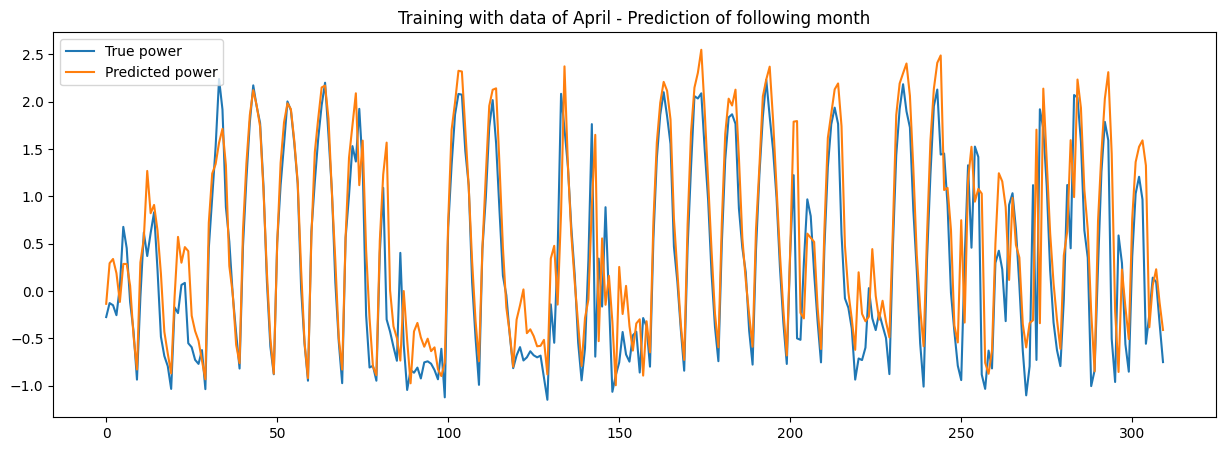

In [59]:
# Plot for a selected month the true power and the predicted power

month = 'April'

outs_valid_values = df[df.month == month]['outs_valid'].values[0]
y_valid_values = df[df.month == month]['y_valid'].values[0]

plt.figure(figsize=(15, 5))
plt.plot(y_valid_values, label='True power')
plt.plot(outs_valid_values, label='Predicted power')
plt.title(f'Training with data of {month} - Prediction of following month')
plt.legend(loc='best')
plt.show()

> The results are the worst when there is a notable change in the month weather. We can see that the results are less good when training with April and predicting May. For similar months, (e.g. May -> June) the results are better.